In [ ]:
!apt update
!apt install -y cmake
!apt-get install -y build-essential autoconf libtool pkg-config
!apt-get install flex bison libbz2-dev
!pip install nle
!pip install minihack
# !python -m minihack.scripts.env_list
!pip install gym[atari,accept-rom-license]

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Sources [2,184 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:13 https://develope

In [1]:
import numpy as np 
import gym
import minihack 
from nle import nethack 

import numpy as np 
import random
import matplotlib.pyplot as plt 
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from torch import flatten
import warnings
warnings.filterwarnings("ignore")
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import CrossEntropyLoss

from torch.nn import Sequential, Conv2d, MaxPool2d, Module
from torch.nn import Softmax, Dropout, Sequential

In [10]:
def format_state(state):
    """Formats the state according to the input requirements of the Actor Critic Neural Network"""
    
    # Normalize and reshape for convolutional layer input
    glyphs = state["glyphs"]
    glyphs = glyphs/glyphs.max()
    glyphs = glyphs.reshape((1,1,21,79))
    
    # Normalize the message and reshape for the fully connected layer input 
    message = state["message"]
    if state["message"].max()>0: 
        # Occassionally the message is empty which will cause a Zero Division error 
        message = message/message.max()
    message = message.reshape((1,len(message)))
    
    state = {"glyphs":glyphs,"message":message}
    return state

In [11]:
#cooked
def compute_returns(rewards, gamma=0.99):
    "calculating discounted rewards"
    returns = []
    dis_reward= 0
    for reward in rewards[::-1]:
        dis_reward = reward + gamma*dis_reward
        returns.insert(0,dis_reward) #reversed 
    
    #normalizing the rewards:
    returns = np.array(returns)
    returns = (returns - returns.mean()) / (returns.std())

    return returns

In [56]:
def plot_results(name,rewards):
    plt.figure(figsize=(8,6))

    ave = np.mean(rewards,axis=0)
    plt.plot(ave,label="Average Reward")
    
    plt.title(f"{name}")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.legend(loc=4)
    plt.show()

In [14]:
device = torch.device("cpu")

In [15]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.reshape(input.shape[0], -1)

In [47]:
class ActorCritic3(nn.Module):
    """The Actor Critic Neural Network used to estimate the state value function and action probabilities"""
    def __init__(self,s_size=8,h_size=128, a_size=4):

        # The network architecture follows the popular lenet-5 CNN architeture 
        super(ActorCritic3, self).__init__()

        self.log_probs = []
        self.rewards = []
        self.state_values  = []

        # Initialize first convolutional layer
        self.conv1 = Conv2d(in_channels=1, out_channels=16, kernel_size=(5, 5))

       
        # remaining convolutions, relus, pools, and 3 FC networks
        self.conv2_fc = Sequential(
                            ReLU(),
                            MaxPool2d(kernel_size=(3, 3), stride=(2, 2)),

                            # conv2
                            Conv2d(in_channels=16, out_channels=52,kernel_size=(5, 5)),
                            ReLU(),
                            MaxPool2d(kernel_size=(3, 3), stride=(2, 2)),

                            # Flatten the output from the final pooling layer and pass it through the fully connected layers
                            Flatten(),

                            # fully connected layers for glyph output after convolutional and pooling layers
                            # fc1
                            Linear(in_features=832, out_features=500),
                            ReLU(),

                            # fc2
                            Linear(in_features=500, out_features=128),
                            ReLU(),

                          ) 

        # fully connected network for message input
        # fc3
        self.message_fc = Sequential(
                            Linear(in_features=256, out_features=128),
                            ReLU(),
                          )
        
        #  fully connected for combination of glyphs and message 
        self.combined_fc = Sequential(
                            Linear(in_features=256, out_features=128),
                            ReLU()
                          )

        # To estimate the value function of the state 
        self.value_layer = Linear(128, 1)

        # To calculate the probability of taking each action in the given state
        self.action_layer = Sequential(
                              Linear(128, a_size),
                              Softmax(dim=-1)
                            )


    def forward(self, state):
        
        # Transform the glyph and state arrays into tensors 
        glyphs_t  = torch.from_numpy(state["glyphs"]).float().to(device)
        message_t  = torch.from_numpy(state["message"]).float().to(device)

        # Pass the 2D glyphs input through our convolutional and pooling layers
        glyphs_t = self.conv2_fc(self.conv1(glyphs_t))

        # Pass the message input through a fully connected layer
        message_t = self.message_fc(message_t)

        # Combine glyphs output from convolution and fully connected layers 
        # with message output from fully connected layer 
        # Cat and Concat are used for different versions of PyTorch
        try:
            combined = torch.cat((glyphs_t,message_t),1)
        except:
            combined = torch.concat([glyphs_t,message_t],1)
        
        # Pass glyphs and messaged combination through a fully connected layer
        combined = self.combined_fc(combined)

        state_value = self.value_layer(combined)
        
        action_probs = self.action_layer(combined)

        # a list with the probability of each action over the action space
        action_distribution = Categorical(action_probs)
        # select action
        action = action_distribution.sample()

        self.log_probs.append(action_distribution.log_prob(action))
        self.state_values.append(state_value)
        return action.item()
      
    
    def calculateLoss(self, gamma, returns):
    
        loss = 0
        for logprob, value, reward in zip(self.log_probs, self.state_values, returns):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        return loss

    def reset(self):
        del self.log_probs[:]
        del self.state_values[:]
        del self.rewards[:]


In [50]:
# state = torch.from_numpy(state["glyphs"]).float().to(device)
      
# flatshape = self.flat_shape(state.shape)
def flat_shape(self,input): #if you want to determine flatshape 

      x = torch.zeros(*input)
      x = self.conv1(x)
      x = self.maxpool1(x)
      x = self.conv2(x)
      x = self.maxpool1(x)

      return int(np.prod(x.size()))

In [20]:
def getSeeds(it):
  return np.random.randint(1000, size=it) #5 interations 

In [9]:
network_path = '/content/drive/MyDrive/RL_Project/A2C.pth'
def save_model_weights(network):
    "saves the actor and critic network weights"
    torch.save(network.state_dict(),network_path)

In [58]:
def run(env, model, seed):

    learning_rate = 0.02
    num_episodes = 100
    max_episodes = 1000
    gamma = 0.99
  
    # Setting random seeds (for reproducibility)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    env.seed(seed)
    
    # Initialize optimizer for Actor Critic Network
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # List to store the rewards attained in each episode 
    model_rewards =[]
    
    for i in range(num_episodes):
        # Reset environment
        state = format_state(env.reset())
        # Flag to see if episode has terminated
        done = False
 
        
        for t in range(1, max_episodes):
            #COOKED
            action = model.forward(state)
            
            # Take selected action, observe the reward received, the next state 
            # and whether or not the episode terminated 
            next_state, reward, done, _ = env.step(action)
            next_state = format_state(next_state)
            
            # COOKED
            # Store the reward
            model.rewards.append(reward)
            
            state = next_state
            
            if done:
                break
        
        # Store the reward acquired in the episode and calculate the discounted return of the episode
        model_rewards.append(np.sum(model.rewards))
        returns = compute_returns(model.rewards, gamma)
        returns = torch.from_numpy(returns).float().to(device)
        
        # Print the episode, the reward acquired in the episode and the mean reward over the last 50 episodes 
        
        print("Episode:",i,"Reward:",np.sum(model.rewards),"Average Reward:",np.mean(model_rewards[-50:]),"Steps",t)
        
        # COOKED 
        loss = model.calculateLoss(gamma, returns)   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        model.reset()

    # Store the policy as the neural network model at the final iteration 
    policy = model

    return policy, model_rewards

## Run on MiniHack-Room-5x5-v0

Episode: 0 Reward: -0.25 Average Reward: -0.25 Steps 100
Episode: 1 Reward: 0.8099999999999999 Average Reward: 0.27999999999999997 Steps 39
Episode: 2 Reward: 0.7 Average Reward: 0.41999999999999993 Steps 59
Episode: 3 Reward: -0.96 Average Reward: 0.07499999999999996 Steps 100
Episode: 4 Reward: 0.87 Average Reward: 0.23399999999999999 Steps 21
Episode: 5 Reward: 0.97 Average Reward: 0.35666666666666663 Steps 15
Episode: 6 Reward: 0.9299999999999999 Average Reward: 0.4385714285714285 Steps 16
Episode: 7 Reward: 1.0 Average Reward: 0.5087499999999999 Steps 4
Episode: 8 Reward: 1.0 Average Reward: 0.5633333333333332 Steps 6
Episode: 9 Reward: 1.0 Average Reward: 0.607 Steps 4
Episode: 10 Reward: 0.92 Average Reward: 0.6354545454545454 Steps 20
Episode: 11 Reward: 0.75 Average Reward: 0.6449999999999999 Steps 33
Episode: 12 Reward: 1.0 Average Reward: 0.6723076923076922 Steps 4
Episode: 13 Reward: 1.0 Average Reward: 0.6957142857142856 Steps 4
Episode: 14 Reward: -0.96 Average Reward: 0.

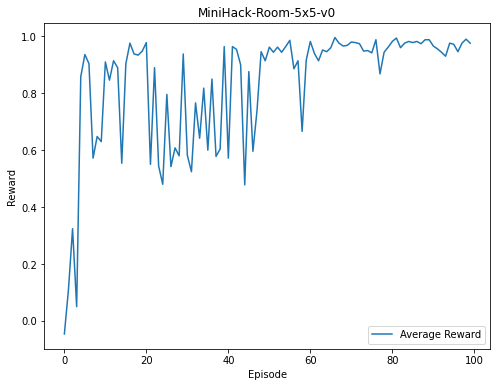

In [59]:
env = gym.make("MiniHack-Room-5x5-v0", observation_keys=["glyphs","pixel","message"],max_episode_steps=1000)
room_rewards = []
state = format_state(env.reset())
seeds = getSeeds(5) #average over 5 runs
for seed in seeds:
  act_critic_model = ActorCritic3(h_size=512, a_size=env.action_space.n)
  policy, model_rewards = run(env=env,model = act_critic_model, seed = seed )
  room_rewards.append(model_rewards)

plot_results("MiniHack-Room-5x5-v0",room_rewards)

## Run on MiniHack-Eat-v0

In [ ]:
eat_rewards = []
moves = tuple(nethack.CompassDirection)
# all_moves = moves + (nethack.Command.EAT,)
env = gym.make("MiniHack-Eat-v0", observation_keys=["glyphs","pixel","message"],
               actions = moves + (nethack.Command.EAT,), max_episode_steps=1000)

seeds = getSeeds(5)
for seed in seeds:
  act_critic_model = ActorCritic3(h_size=512, a_size=env.action_space.n)
  policy, model_rewards = run(env=env,model = act_critic_model, seed = seed )
  eat_rewards.append(model_rewards)

plot_results("MiniHack-Eat-v0",eat_rewards)

Episode: 0 Reward: 0.9 Average Reward: 0.9 Steps 34
Episode: 1 Reward: -2.48 Average Reward: -0.79 Steps 250
Episode: 2 Reward: -2.48 Average Reward: -1.3533333333333335 Steps 250
Episode: 3 Reward: 0.63 Average Reward: -0.8575000000000002 Steps 89
Episode: 4 Reward: -0.8300000000000001 Average Reward: -0.8520000000000001 Steps 250
Episode: 5 Reward: -0.81 Average Reward: -0.8450000000000001 Steps 250
Episode: 6 Reward: 0.3299999999999999 Average Reward: -0.6771428571428572 Steps 177
Episode: 7 Reward: 0.81 Average Reward: -0.4912500000000001 Steps 42
Episode: 8 Reward: -1.1500000000000001 Average Reward: -0.5644444444444445 Steps 250
Episode: 9 Reward: -0.87 Average Reward: -0.5950000000000001 Steps 250
Episode: 10 Reward: 0.2499999999999999 Average Reward: -0.5181818181818183 Steps 205
Episode: 11 Reward: -1.1400000000000001 Average Reward: -0.5700000000000002 Steps 250
Episode: 12 Reward: 0.5699999999999998 Average Reward: -0.48230769230769244 Steps 112
Episode: 13 Reward: -1.03 Ave

## Run on MiniHack-WoD-Easy-v0

In [27]:
 
env = gym.make("MiniHack-WoD-Easy-v0", observation_keys=["glyphs","pixel","message"],max_episode_steps=1000)
 
WoD_rewards = []

seeds = getSeeds(5)
for seed in seeds:
  act_critic_model = ActorCritic3(h_size=512, a_size=env.action_space.n)
  policy, model_rewards = run(env=env,model = act_critic_model, seed = seed)
  WoD_rewards .append(model_rewards)

plot_results("MiniHack-WoD-Easy-v0",WoD_rewards)

Episode: 0 Reward: -0.45000000000000007 Average Reward: -0.45000000000000007 Steps 50
Episode: 1 Reward: -0.5 Average Reward: -0.47500000000000003 Steps 50
Episode: 2 Reward: -0.4700000000000001 Average Reward: -0.4733333333333334 Steps 50


KeyboardInterrupt: ignored

## Run on MiniHack-Quest-Hard-v0

In [29]:
# Custom Reward for exploring more of the map 
def maze_explore_reward(env, prev_obs, action, next_obs):
    if (prev_obs[0] == 2359).sum() > (next_obs[0] == 2359).sum():
        return 0.1
    return 0

In [30]:
# Reward Manager for including custom rewards
from minihack import RewardManager

reward_gen = RewardManager()


reward_gen.add_eat_event("apple", reward=1)

# Custom Rewards for long corridors at top and bottom 
reward_gen.add_coordinate_event((3,27), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((3,28), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((3,29), reward = -5, terminal_required = False)

reward_gen.add_coordinate_event((19,27), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((19,28), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((19,29), reward = -5, terminal_required = False)

reward_gen.add_coordinate_event((11,27), reward = 100, terminal_required = False)# first door at end of maze

#our rewards 
reward_gen.add_kill_event("minotaur", reward=11)
strings = list()
strings.append("The door opens.")
reward_gen.add_message_event(strings, reward=1)
######
strings = list()
strings.append("It's solid stone.")
reward_gen.add_message_event(strings, reward=-0.75)

reward_gen.add_custom_reward_fn(maze_explore_reward)

In [32]:
moves = tuple(nethack.CompassDirection)
ACTIONS = moves + ( 
    nethack.CompassDirection.NW,
    nethack.Command.PICKUP,
    nethack.Command.APPLY,
    nethack.Command.FIRE,
    nethack.Command.RUSH,
    nethack.Command.ZAP, 
    nethack.Command.PUTON,
    nethack.Command.AUTOPICKUP,
    nethack.Command.OPEN,
    nethack.Command.KICK,
    nethack.Command.READ,
    nethack.Command.SEARCH,
    nethack.Command.WEAR,
    nethack.Command.WIELD,
    nethack.Command.QUAFF
)

env = gym.make("MiniHack-Quest-Hard-v0", reward_lose = -10, reward_win = 10, reward_manager = reward_gen, actions = ACTIONS)


quest_hard_rewards =[]
seeds = getSeeds(3)
state = format_state(env.reset())
for seed in seeds:
  act_critic_model = ActorCritic3(h_size=512, a_size=env.action_space.n)
  policy, model_rewards = run(env=env,model = act_critic_model, seed = seed )
  quest_hard_rewards.append(model_rewards)

plot_results("MiniHack-Quest-Hard-v0",quest_hard_rewards)

KeyboardInterrupt: ignored